# Combine multi-country HLA data
We can calculate the average allele frequency of multiple countries
by combining studies within countries and then between countries.
This second step is very similar except we set `datasetID` as the country
rather than the population, which is the default.

The estimates from different countries can be weighted by sample size or another supplied variable such as population size. Both are described below.

In [1]:
import HLAfreq
from HLAfreq import HLAfreq_pymc as HLAhdi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Download HLA data for each specified country

In [2]:
countries = ['Cameroon','Cape+Verde','Ghana','Guinea',
    'Guinea-Bissau', 'Kenya','Sao+Tome+and+Principe','Senegal',
    'South+Africa','Uganda','Zimbabwe']

In [3]:
for country in countries:
    print(country)
    base_url = HLAfreq.makeURL(
        country, standard='s', locus="A",
        resolution_pattern="bigger_equal_than", resolution=2)
    aftab = HLAfreq.getAFdata(base_url)
    aftab.to_csv("../data/example/multi_country/%s_raw.csv" %country, index=False)

Cameroon
2 pages of results
Download complete
Cape+Verde
1 pages of results
Download complete
Ghana
1 pages of results
Download complete
Guinea
3 pages of results
Download complete
Guinea-Bissau
2 pages of results
Download complete
Kenya
2 pages of results
Download complete
Sao+Tome+and+Principe
1 pages of results
Download complete
Senegal
1 pages of results
Download complete
South+Africa
3 pages of results
Download complete
Uganda
1 pages of results
Download complete
Zimbabwe
1 pages of results
Download complete


## Combine allele frequencies within country

In [4]:
cafs = []
for country in countries:
    # Load raw country data
    aftab = pd.read_csv("../data/example/multi_country/%s_raw.csv" %country)
    # Drop any incomplete studies
    aftab = HLAfreq.only_complete(aftab)
    # Ensure all alleles have the same resolution
    aftab = HLAfreq.decrease_resolution(aftab, 2)
    # Combine studies within country
    caf = HLAfreq.combineAF(aftab)
    # Add country name to dataset, this is used as `datasetID` going forward
    caf['country'] = country
    cafs.append(caf)


population               loci
South Africa Natal Zulu  A       0.935
Name: allele_freq, dtype: float64
1 studies have total allele frequency < 0.95


## Combine all country data
Concatenate each single country dataset into a single multicountry dataset.
Combine allele frequencies, using the manually added `country` column as `datasetID`.

In [5]:
cafs = pd.concat(cafs, ignore_index=True)
international = HLAfreq.combineAF(cafs, datasetID='country')

# View allele frequencies
Plot allele frequencies averaged across countries.
Filter to only alleles with >1% frequency after averaging.

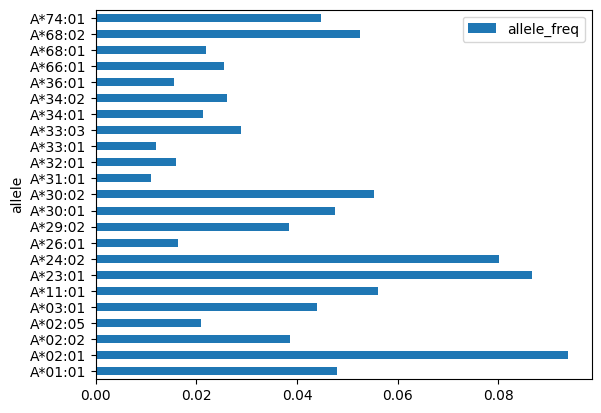

In [6]:
# Plot international averages as bar plot
mask = international.allele_freq > 0.01
international[mask].plot.barh('allele', 'allele_freq')
plt.show()

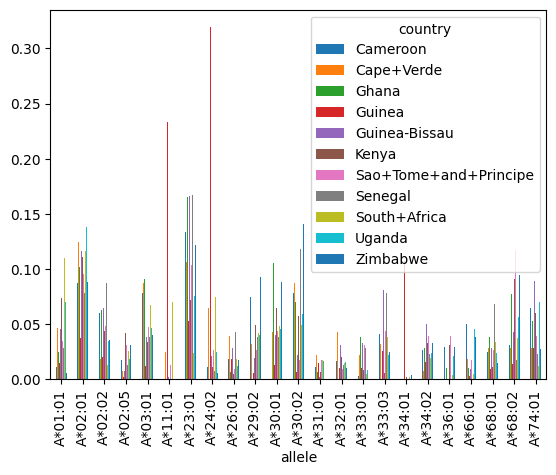

In [7]:
mask2 = cafs.allele.isin(international.allele[mask])
# Plot national averages as grouped bar plot
cafs[mask2].pivot(index='allele', columns='country', values='allele_freq').plot.bar()
plt.show()

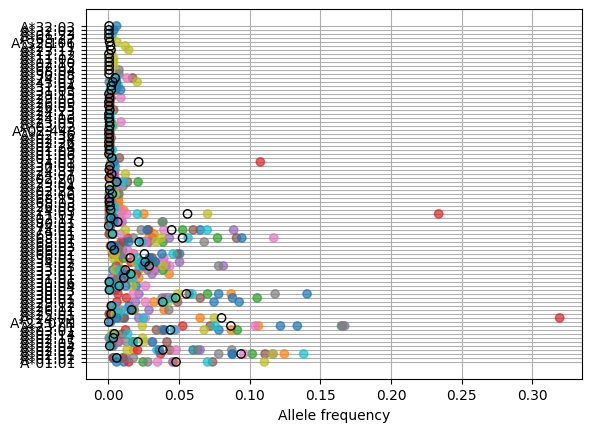

In [8]:
# Plot international allele frequencies estimates and individual countries
# Without filtering
HLAfreq.plotAF(international, cafs, datasetID='country')

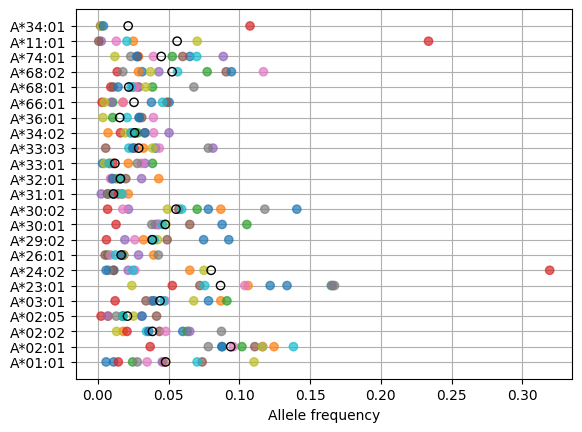

In [9]:
# Plot specific alleles
# Select alleles to plot
hifreq = international[international.allele_freq > 0.01].allele
# Must be a list
hifreq = hifreq.tolist()
# Plot only selected alleles
HLAfreq.plotAF(
    international[international.allele.isin(hifreq)],
    cafs[cafs.allele.isin(hifreq)],
    datasetID='country')

From these plots we can clearly see that one country has much
higher frequencies of A\*24:02, A\*11:01, and A\*34:01.
It is also clear that the international average allele
frequency for A\*24:02 is being skewed by this country. We can view the
`cafs` dataset to see which country this is, Guinea.
For more info on dealing with outliers and this skewing, see the [credible intervals example](https://github.com/Vaccitech/HLAfreq/blob/main/examples/credible_intervals.ipynb).

This method can
also be applied to individual countries to identify studies which
differ from the majority, possibly because it focuses on a specific
ethnic group.

In [10]:
cafs[cafs.allele == "A*24:02"].sort_values('allele_freq')

,allele,loci,wav,c,sample_size,alpha,allele_freq,country
383,A*24:02,A,0.004000,1.8400,230,1,0.005818,Zimbabwe
262,A*24:02,A,0.005000,1.6500,165,1,0.007458,Senegal
183,A*24:02,A,0.010700,16.0280,749,1,0.010936,Kenya
11,A*24:02,A,0.010322,5.9660,289,1,0.011301,Cameroon
136,A*24:02,A,0.020740,7.9640,192,1,0.021445,Guinea-Bissau
342,A*24:02,A,0.025292,16.9960,336,1,0.024831,Uganda
231,A*24:02,A,0.025449,4.9880,98,1,0.026148,Sao+Tome+and+Principe
45,A*24:02,A,0.068500,16.9880,124,1,0.064939,Cape+Verde
297,A*24:02,A,0.077965,61.5924,395,1,0.074961,South+Africa
99,A*24:02,A,0.327856,419.6560,640,1,0.319246,Guinea


It is important to do a sanity check on any apparent outliers. In this case the apparent outlier of Guinea is actually caused by our search returning studies for Guinea-Bissau and Papua New Guinea

In [11]:
aftab = pd.read_csv("../data/example/multi_country/Guinea_raw.csv")
aftab.population.unique()

array(['Guinea Bissau Balanta', 'Guinea Bissau Bijago',
       'Guinea Bissau Fula', 'Guinea Bissau Papel', 'Guinea Bissau',
       'Papua New Guinea East New Britain Rabaul',
       'Papua New Guinea Eastern Highlands Goroka Asaro',
       'Papua New Guinea Karimui Plateau Pawaia',
       'Papua New Guinea Madang',
       'Papua New Guinea West Schrader Ranges Haruai',
       'Papua New Guinea Wosera Abelam'], dtype=object)

## Weighting countries by population size
When combining allele frequencies across studies, larger studies are given more weight. This is handled by the `weights` parameter. (Specifically the `weights` is multiplied by the allele frequency to calculate the "concentration" of the Dirichlet distribution before adding the prior). By default `weights` is double the sample size as two alleles are measured for each person sampled due to diploidy. However, alternative `weights` can be specified. The interpretation of the column used for `weights` is that $n$
samples were observed with allele $x$.

If estimating allele frequency for a region, it may be important to
account for the size of national populations. Below we calculate an
individual weight for each country. A country's population, as a proportion
of the sum of countries' populations, multiplied by the number of countries is
used as the weight for each individual in that country. This means that
individuals from large countries contibute more to the total sample but the total sample size is unchanged. Therefore, the uncertainty of estimates is still determined by the overall sample size.

In [12]:
population_sizes = {'Cameroon':24348251,
    'Cape+Verde':563198,
    'Ghana':30832019,
    'Guinea':12907395,
    'Guinea-Bissau':1646077,
    'Kenya':47564296,
    'Sao+Tome+and+Principe':214610,
    'Senegal':17223497,
    'South+Africa':60604992,
    'Uganda':42885900,
    'Zimbabwe':15178979
}

country_data = pd.DataFrame(
    {'country':population_sizes.keys(),
    'population':population_sizes.values()}
)

# What proportion of the regional population does each country account for
country_data['proportion'] = country_data.population/country_data.population.sum()
# How much will each individual in the country count towards the sample size?
country_data['individual_weight'] = country_data['proportion'] * len(country_data.country)


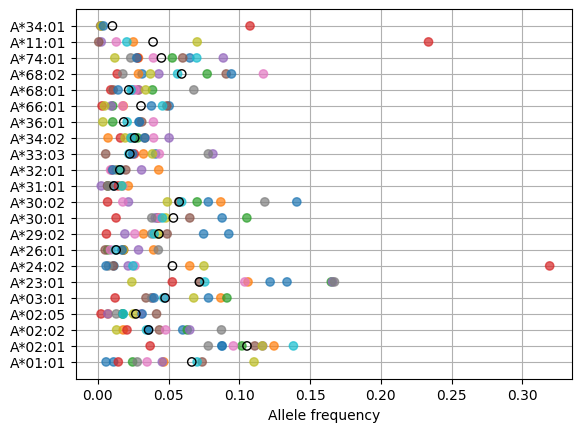

In [13]:
# Add country data to Combined Allele Frequency data
cafs = pd.merge(cafs, country_data, how="left", on='country')
# Sample size is multiplied by this individual weight and doubled
# this accounts for diploid samples from each individual
cafs['weighted_sample_size'] = cafs.sample_size * 2 * cafs.individual_weight

# Calculate allele frequency, weighting each country by the column weighted_sample_szie
winternational = HLAfreq.combineAF(cafs, datasetID='country', weights='weighted_sample_size')

hifreq = winternational[winternational.allele_freq > 0.01].allele
# Must be a list
hifreq = hifreq.tolist()
# Plot only selected alleles
HLAfreq.plotAF(
    winternational[winternational.allele.isin(hifreq)],
    cafs[cafs.allele.isin(hifreq)],
    datasetID='country')

## Credible intervals and population size
The approach above should only be used for the default model. If you want to account for population size using the compound model to get credible intervals the approach is a little different. A different approach is needed because the compound model accounts for study variance and the above weighting will chiefly affect that variance rather than the total allele frequency.
The solution to accounting for population size when estimating credible intervals is to calculate the country specific allele frequencies first and then weight the country estimates before combining them. In this case, slightly different from above, we weight by the country's proportion of the total population. This different weighting is because sample size is already accounted for when estimating country allele frequencies.

Load the allele frequency data so that each country is an element in a list. This is the non-combined data we downloaded earlier. This time we're skipping Guinea because the data wasn't actually from Guinea.

In [14]:
countries = ['Cameroon','Cape+Verde','Ghana',
    'Guinea-Bissau', 'Kenya','Sao+Tome+and+Principe','Senegal',
    'South+Africa','Uganda','Zimbabwe']
aftabs = []
for country in countries:
  # Load raw country data
  aftab = pd.read_csv("../data/example/multi_country/%s_raw.csv" %country)
  # Drop any incomplete studies
  aftab = HLAfreq.only_complete(aftab)
  # Ensure all alleles have the same resolution
  aftab = HLAfreq.decrease_resolution(aftab, 2)
  aftab['country'] = country
  aftabs.append(aftab)


population               loci
South Africa Natal Zulu  A       0.935
Name: allele_freq, dtype: float64
1 studies have total allele frequency < 0.95


In order to combine different countries they must have the same alleles. The easiest way to do this is using `HLAfreq.unmeasured_alleles()`. So we will join all the country datasets up, add the missing alleles, then split them apart again.

In [15]:
# Join them up
all_aftabs = pd.concat(aftabs)

# Add the missing alleles
all_aftabs = HLAfreq.unmeasured_alleles(all_aftabs, datasetID='population')

# Split them apart again
aftabs = []
for country in countries:
  # List all populations in a given country
  country_populations = all_aftabs[all_aftabs.country == country].population.unique()
  # Select all data from a population in the given country
  mask = all_aftabs.population.isin(country_populations)
  aftabs.append(all_aftabs[mask])

Next we fit the compound model for each country separately. Because we need access to the underlying trace, we fit the model with internal functions rather than `AFhdi()`.

In [16]:
idatas = []
for i,aftab in enumerate(aftabs):
  print(countries[i])
  # fit pymc model to each dataset separately
  c_array, allele_names = HLAhdi._make_c_array(aftab)
  idata = HLAhdi._fit_Dirichlet_Multinomial(c_array)
  idatas.append(idata)

Cameroon


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


Cape+Verde


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Ghana


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


Guinea-Bissau


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Kenya


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Sao+Tome+and+Principe


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Senegal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


South+Africa


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Uganda


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


Zimbabwe


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


As we're not including Guinea this time we have to recalculate the population size proportions otherwise our weights will not sum to one and neither will our allele frequencies.

In [17]:
population_sizes = {'Cameroon':24348251,
    'Cape+Verde':563198,
    'Ghana':30832019,
    # 'Guinea':12907395,
    'Guinea-Bissau':1646077,
    'Kenya':47564296,
    'Sao+Tome+and+Principe':214610,
    'Senegal':17223497,
    'South+Africa':60604992,
    'Uganda':42885900,
    'Zimbabwe':15178979
}

country_data = pd.DataFrame(
    {'country':population_sizes.keys(),
    'population':population_sizes.values()}
)

# What proportion of the regional population does each country account for
country_data['proportion'] = country_data.population/country_data.population.sum()

Next we take the estimate for each country and multiply it by the population proportion for that country. Finally we sum these weighted estimates.

In [18]:
weighted_country_estimates = []
for i,country in enumerate(countries):
    # Country specific weight
    weight = country_data[country_data.country==country].proportion.values
    # Weighting the country estimate
    weighted_country_estimate = idatas[i].posterior['frac'] * weight
    weighted_country_estimates.append(weighted_country_estimate)

# Sum all the weighted country estimates
weighted_international_estimate = sum(weighted_country_estimates)

# Get model summary
summary = az.summary(weighted_international_estimate)
# Add the allele names on to the summary
# these were produced when we made c_array
summary.index = allele_names
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A*01:01,0.040,0.007,0.028,0.054,0.0,0.0,4128.0,3365.0,1.0
A*01:02,0.009,0.003,0.005,0.014,0.0,0.0,4615.0,3709.0,1.0
A*01:03,0.008,0.002,0.004,0.013,0.0,0.0,3747.0,3452.0,1.0
A*01:06,0.005,0.002,0.002,0.009,0.0,0.0,5086.0,3560.0,1.0
A*01:09,0.006,0.002,0.002,0.010,0.0,0.0,4828.0,3588.0,1.0
...,...,...,...,...,...,...,...,...,...
A*69:01,0.007,0.002,0.003,0.011,0.0,0.0,5330.0,3755.0,1.0
A*74:01,0.027,0.005,0.017,0.037,0.0,0.0,4433.0,3294.0,1.0
A*74:02,0.005,0.002,0.002,0.008,0.0,0.0,5237.0,3646.0,1.0
A*74:03,0.009,0.003,0.004,0.014,0.0,0.0,4620.0,3717.0,1.0


It's important to check the compound models by comparing to the default model. Below we plot the population size weighted default model estimates against the population weighted compound model estimates. Unfortunately they are not as similar as we'd like. The compound model is overestimating rare alleles and underestimating common alleles. This suggests an overly informative prior pulling all alleles to an average frequency. For more detail on this issue see the [working with priors](https://github.com/Vaccitech/HLAfreq/blob/main/examples/working_with_priors.ipynb) example.

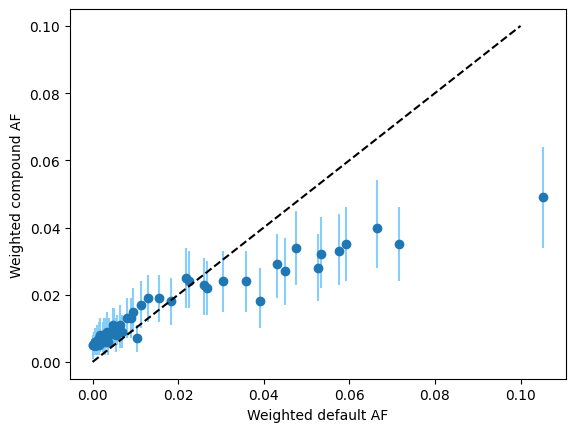

In [88]:
plt.scatter(winternational.allele_freq, summary['mean'])
plt.vlines(x=winternational.allele_freq, ymin=summary['hdi_3%'], ymax=summary['hdi_97%'], color="lightskyblue", zorder=0)
plt.plot([0,.1],[0,.1], c="black", linestyle="--")
plt.xlabel('Weighted default AF')
plt.ylabel('Weighted compound AF')
plt.show()

The solution is to use a different prior. Instead of $1$ for each allele, use $1/k$ where $k$ is the number of alleles. It's a simple fix but the downside is that it runs much slower.

In [56]:
idatas2 = []
for i,aftab in enumerate(aftabs):
  print(countries[i])
  # fit pymc model to each dataset separately
  c_array, allele_names = HLAhdi._make_c_array(aftab)
  # number of alleles
  k = len(aftab.allele.unique())
  # use 1/k prior
  idata = HLAhdi._fit_Dirichlet_Multinomial(c_array, prior=[1/k]*k)
  idatas2.append(idata)

Cameroon


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 272 seconds.


Cape+Verde


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 285 seconds.


Ghana


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 308 seconds.


Guinea-Bissau


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 319 seconds.


Kenya


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 348 seconds.


Sao+Tome+and+Principe


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 288 seconds.


Senegal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 308 seconds.


South+Africa


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 317 seconds.


Uganda


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 297 seconds.


Zimbabwe


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 277 seconds.


Now the models have finished running, weight and sum the traces. This is exactly the same as before.

In [57]:
weighted_country_estimates2 = []
for i,country in enumerate(countries):
    # Country specific weight
    weight = country_data[country_data.country==country].proportion.values
    # Weighting the country estimate
    weighted_country_estimate = idatas2[i].posterior['frac'] * weight
    weighted_country_estimates2.append(weighted_country_estimate)

# Sum all the weighted country estimates
weighted_international_estimate2 = sum(weighted_country_estimates2)

# Get model summary
summary2 = az.summary(weighted_international_estimate2)
# Add the allele names on to the summary
# these were produced when we made c_array
summary2.index = allele_names
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A*01:01,0.063,0.009,0.047,0.079,0.0,0.0,1774.0,2231.0,1.00
A*01:02,0.004,0.002,0.002,0.007,0.0,0.0,1002.0,1315.0,1.00
A*01:03,0.003,0.001,0.001,0.005,0.0,0.0,1903.0,2290.0,1.00
A*01:06,0.000,0.000,0.000,0.001,0.0,0.0,1894.0,1317.0,1.00
A*01:09,0.001,0.001,0.000,0.002,0.0,0.0,1221.0,1575.0,1.00
...,...,...,...,...,...,...,...,...,...
A*69:01,0.002,0.001,0.000,0.004,0.0,0.0,1373.0,1856.0,1.00
A*74:01,0.042,0.006,0.030,0.053,0.0,0.0,886.0,1661.0,1.01
A*74:02,0.000,0.000,0.000,0.000,0.0,0.0,1240.0,1675.0,1.00
A*74:03,0.004,0.001,0.001,0.006,0.0,0.0,2653.0,2560.0,1.00


Now when we compare the weighted default and weighted compound estimates they are in much better agreement. Remember though that we didn't exclude the incorrect Guinea data for the default model so we should really redo the compound model without Guinea.

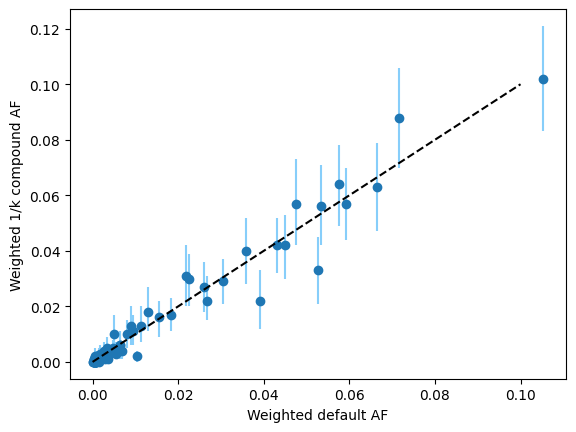

In [89]:
plt.scatter(winternational.allele_freq, summary2['mean'])
plt.vlines(x=winternational.allele_freq, ymin=summary2['hdi_3%'], ymax=summary2['hdi_97%'], color="lightskyblue", zorder=0)
plt.plot([0,.1],[0,.1], c="black", linestyle="--")
plt.xlabel('Weighted default AF')
plt.ylabel('Weighted 1/k compound AF')
plt.show()

In [ ]:
# az.summary() gives 96% credible intervals
# but any interval can be obtained with az.hdi()
az.hdi(weighted_international_estimate2, 0.95).frac.values

array([[0.02759661, 0.0548428 ],
       [0.00452285, 0.01433677],
       [0.00377304, 0.0129694 ],
       [0.00176486, 0.00881422],
       [0.00231861, 0.01024124],
       [0.00203228, 0.00954437],
       [0.03415686, 0.06497219],
       [0.01573759, 0.03394972],
       [0.00235762, 0.01074451],
       [0.0021822 , 0.00932612],
       [0.01403252, 0.03101837],
       [0.00373039, 0.01356755],
       [0.00196443, 0.00987427],
       [0.00434116, 0.01517492],
       [0.00564147, 0.01691425],
       [0.0026366 , 0.01053915],
       [0.00148889, 0.00845054],
       [0.00176905, 0.00898124],
       [0.00234081, 0.01046179],
       [0.00186188, 0.00876754],
       [0.00203182, 0.00905159],
       [0.00193571, 0.00895337],
       [0.00179998, 0.00900889],
       [0.02321528, 0.04599152],
       [0.00311518, 0.01205201],
       [0.00896835, 0.02769771],
       [0.00189439, 0.00985112],
       [0.00206027, 0.00961964],
       [0.02288719, 0.04653844],
       [0.00210568, 0.0104285 ],
       [0.

array([[<AxesSubplot: title={'center': 'frac'}>,
        <AxesSubplot: title={'center': 'frac'}>]], dtype=object)

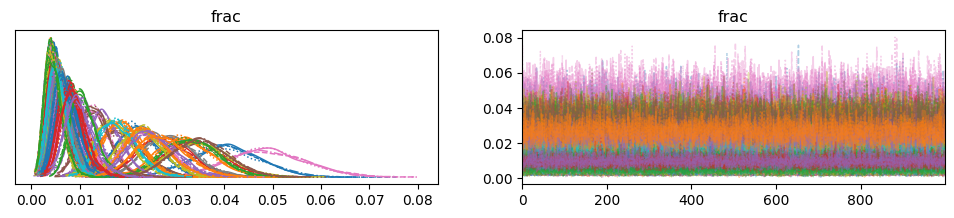

In [ ]:
# This object can be fully explored using arviz like any other pymc model
az.plot_trace(weighted_international_estimate2)